# 03 — MDP OPE Walkthrough

We compare trajectory-based estimators on a synthetic MDP and interpret
horizon effects and diagnostics.

## Setup

```
pip install "causalrl[plots]"
```

In [1]:
from __future__ import annotations

from pathlib import Path

import numpy as np

from crl.assumptions import AssumptionSet
from crl.assumptions_catalog import MARKOV, OVERLAP, SEQUENTIAL_IGNORABILITY
from crl.benchmarks.mdp_synth import SyntheticMDP, SyntheticMDPConfig
from crl.estimands.policy_value import PolicyValueEstimand
from crl.estimators.dual_dice import DualDICEConfig, DualDICEEstimator
from crl.ope import evaluate
from crl.utils.seeding import set_seed
from crl.viz import configure_notebook_display, save_figure

In [2]:
set_seed(0)
np.random.seed(0)
configure_notebook_display()

## Run estimators

In [3]:
benchmark = SyntheticMDP(SyntheticMDPConfig(seed=0, horizon=5))
dataset = benchmark.sample(num_trajectories=200, seed=1)
true_value = benchmark.true_policy_value(benchmark.target_policy)

report = evaluate(
    dataset=dataset,
    policy=benchmark.target_policy,
    estimators=["is", "wis", "pdis", "dr", "mis", "dualdice", "fqe"],
)
summary = report.summary_table()
summary

value     stderr                                          ci  \
0  -3.082840   3.551091   (-10.042977932983256, 3.8772969819633696)   
1  -0.045110   0.127437  (-0.2948870684576913, 0.20466711264087695)   
2  52.903821  51.642935    (-48.31633133827914, 154.12397393169556)   
3 -85.134460  87.018072    (-255.68988233413336, 85.42096150884583)   
4   1.814114   0.032358      (1.750692867432645, 1.877534386617597)   

                                         diagnostics  \
0  {'overlap': {'min_behavior_prob': 0.0140824109...   
1  {'overlap': {'min_behavior_prob': 0.0140824109...   
2  {'overlap': {'min_behavior_prob': 0.0140824109...   
3  {'overlap': {'min_behavior_prob': 0.0140824109...   
4  {'overlap': {'min_behavior_prob': 0.0140824109...   

                          assumptions_checked assumptions_flagged  \
0          [sequential_ignorability, overlap]                  []   
1          [sequential_ignorability, overlap]                  []   
2          [sequential_ignorability, overlap]                  []   
3  [sequential_ignorability, overlap, markov]                  []   
4  [sequential_ignorability, overlap, markov]                  []   

                                            warnings  \
0  [Effective sample size ratio below threshold; ...   
1  [Effective sample size ratio below threshold; ...   
2  [Effective sample size ratio below threshold; ...   
3  [Effective sample size ratio below threshold; ...   
4  [Effective sample size ratio below threshold; ...   

                                            metadata  lower_bound  \
0  {'estimator': 'IS', 'num_trajectories': 200, '...   -10.042978   
1  {'estimator': 'WIS', 'num_trajectories': 200, ...    -0.294887   
2  {'estimator': 'PDIS', 'num_trajectories': 200,...   -48.316331   
3  {'estimator': 'DR', 'config': {'num_folds': 2,...  -255.689882   
4  {'estimator': 'FQE', 'config': {'hidden_sizes'...     1.750693   

   upper_bound estimator  
0     3.877297        IS  
1     0.204667       WIS  
2   154.123974      PDIS  
3    85.420962        DR  
4     1.877534       FQE

## DualDICE configuration example

DualDICE is a behavior-agnostic estimator for discrete MDPs. Here we use a
custom ridge setting to illustrate configuration.

In [ ]:
estimand = PolicyValueEstimand(
    policy=benchmark.target_policy,
    discount=dataset.discount,
    horizon=dataset.horizon,
    assumptions=AssumptionSet([SEQUENTIAL_IGNORABILITY, OVERLAP, MARKOV]),
)

dualdice_config = DualDICEConfig(ridge=5e-3, normalize=False)
dualdice_report = DualDICEEstimator(estimand, config=dualdice_config).estimate(dataset)
dualdice_report.to_dataframe()

## Visual comparison

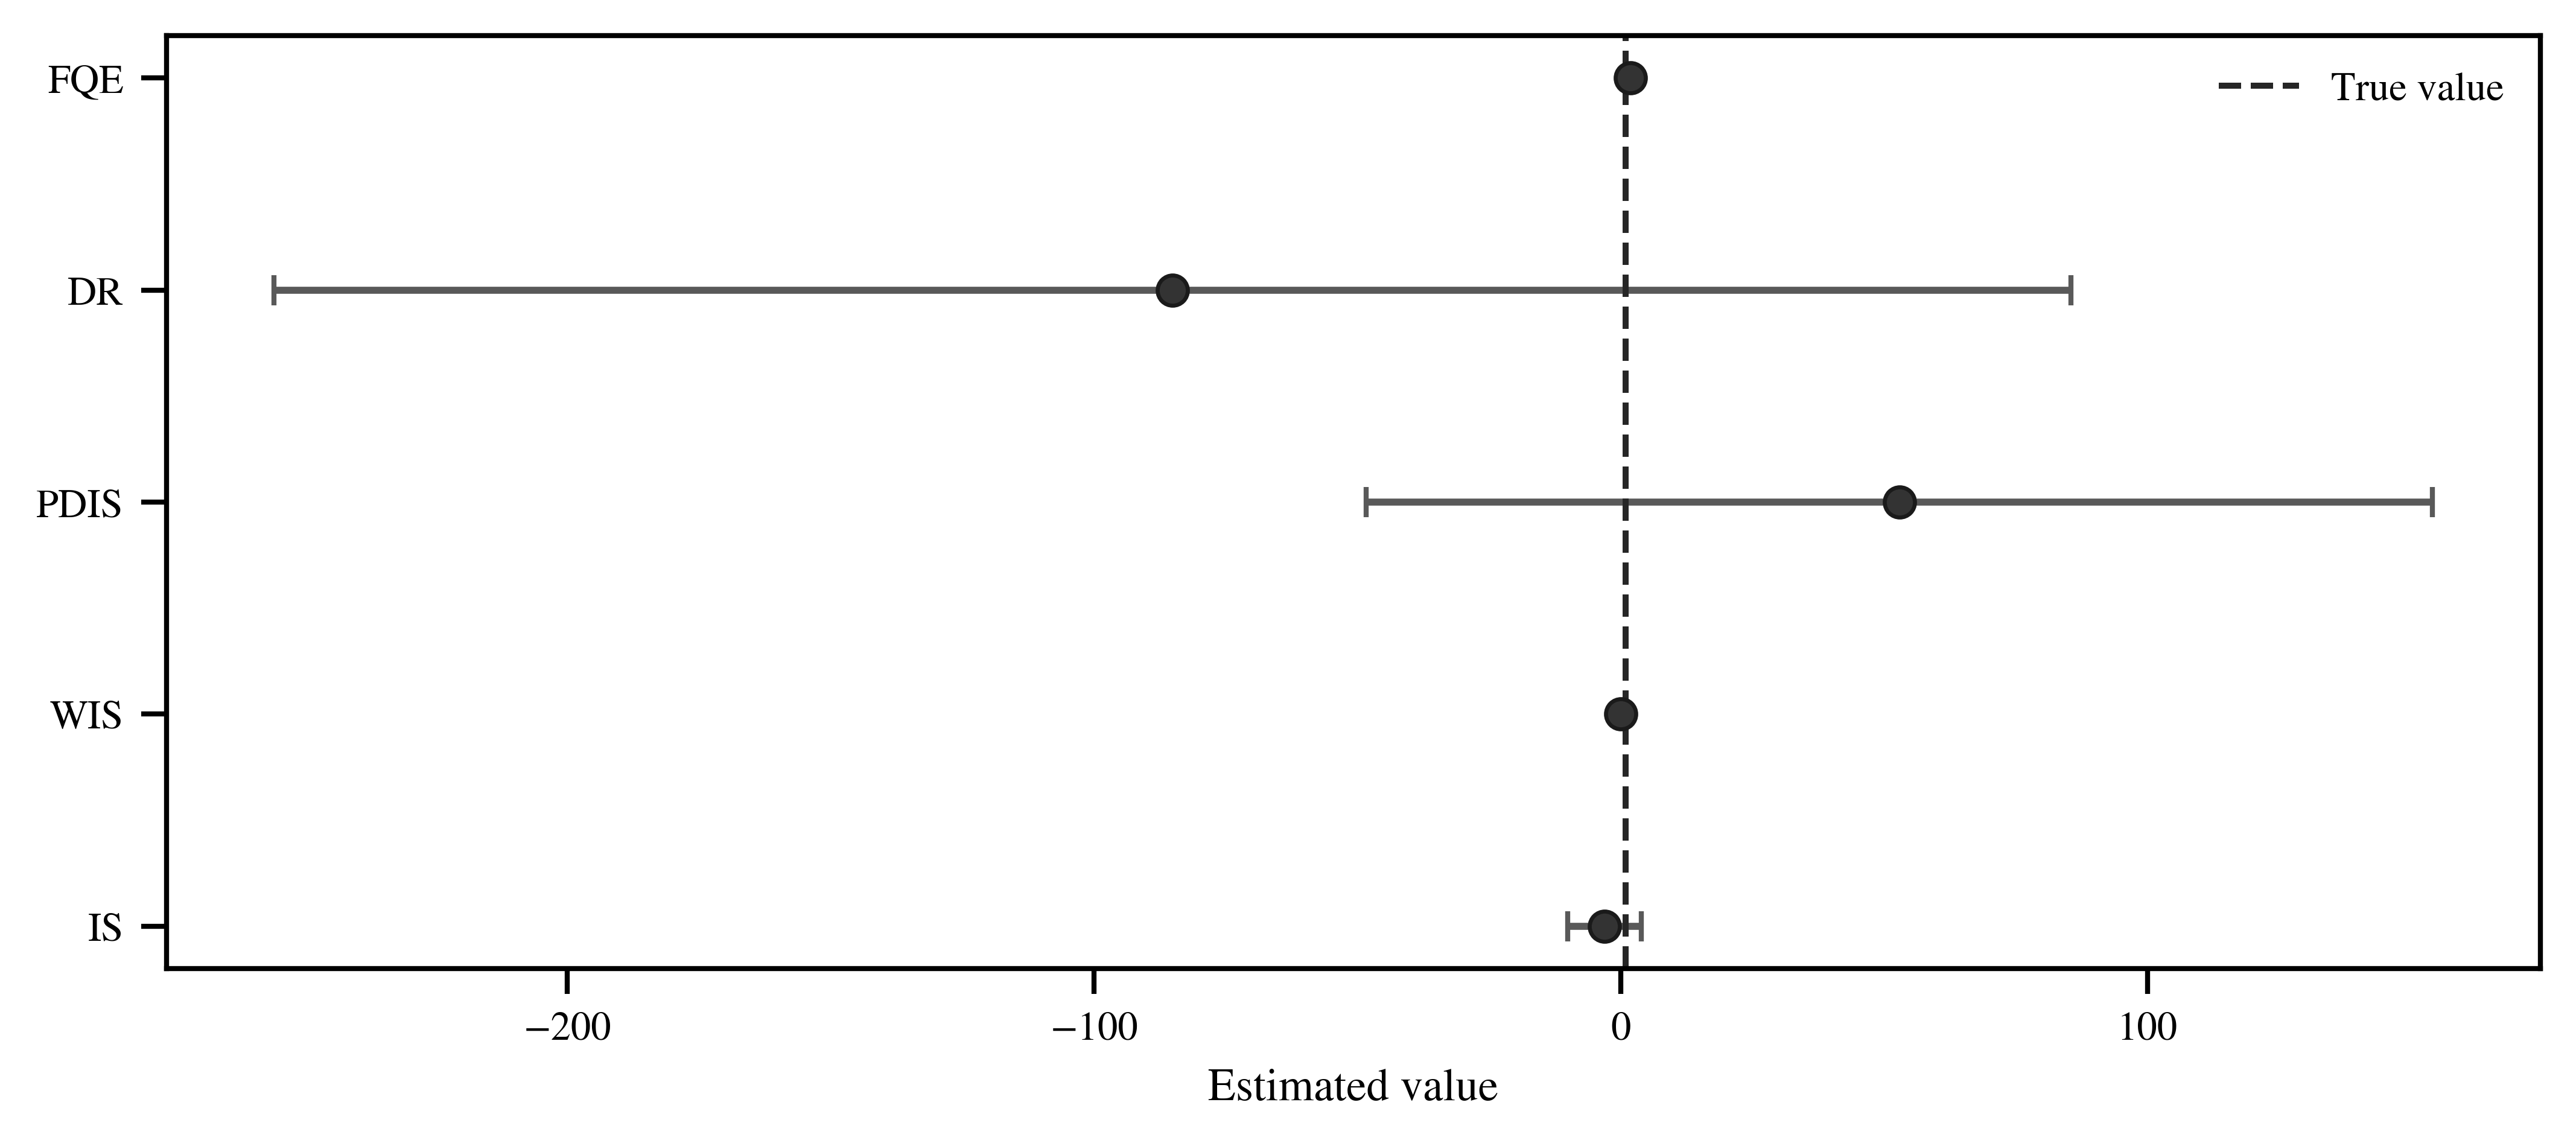

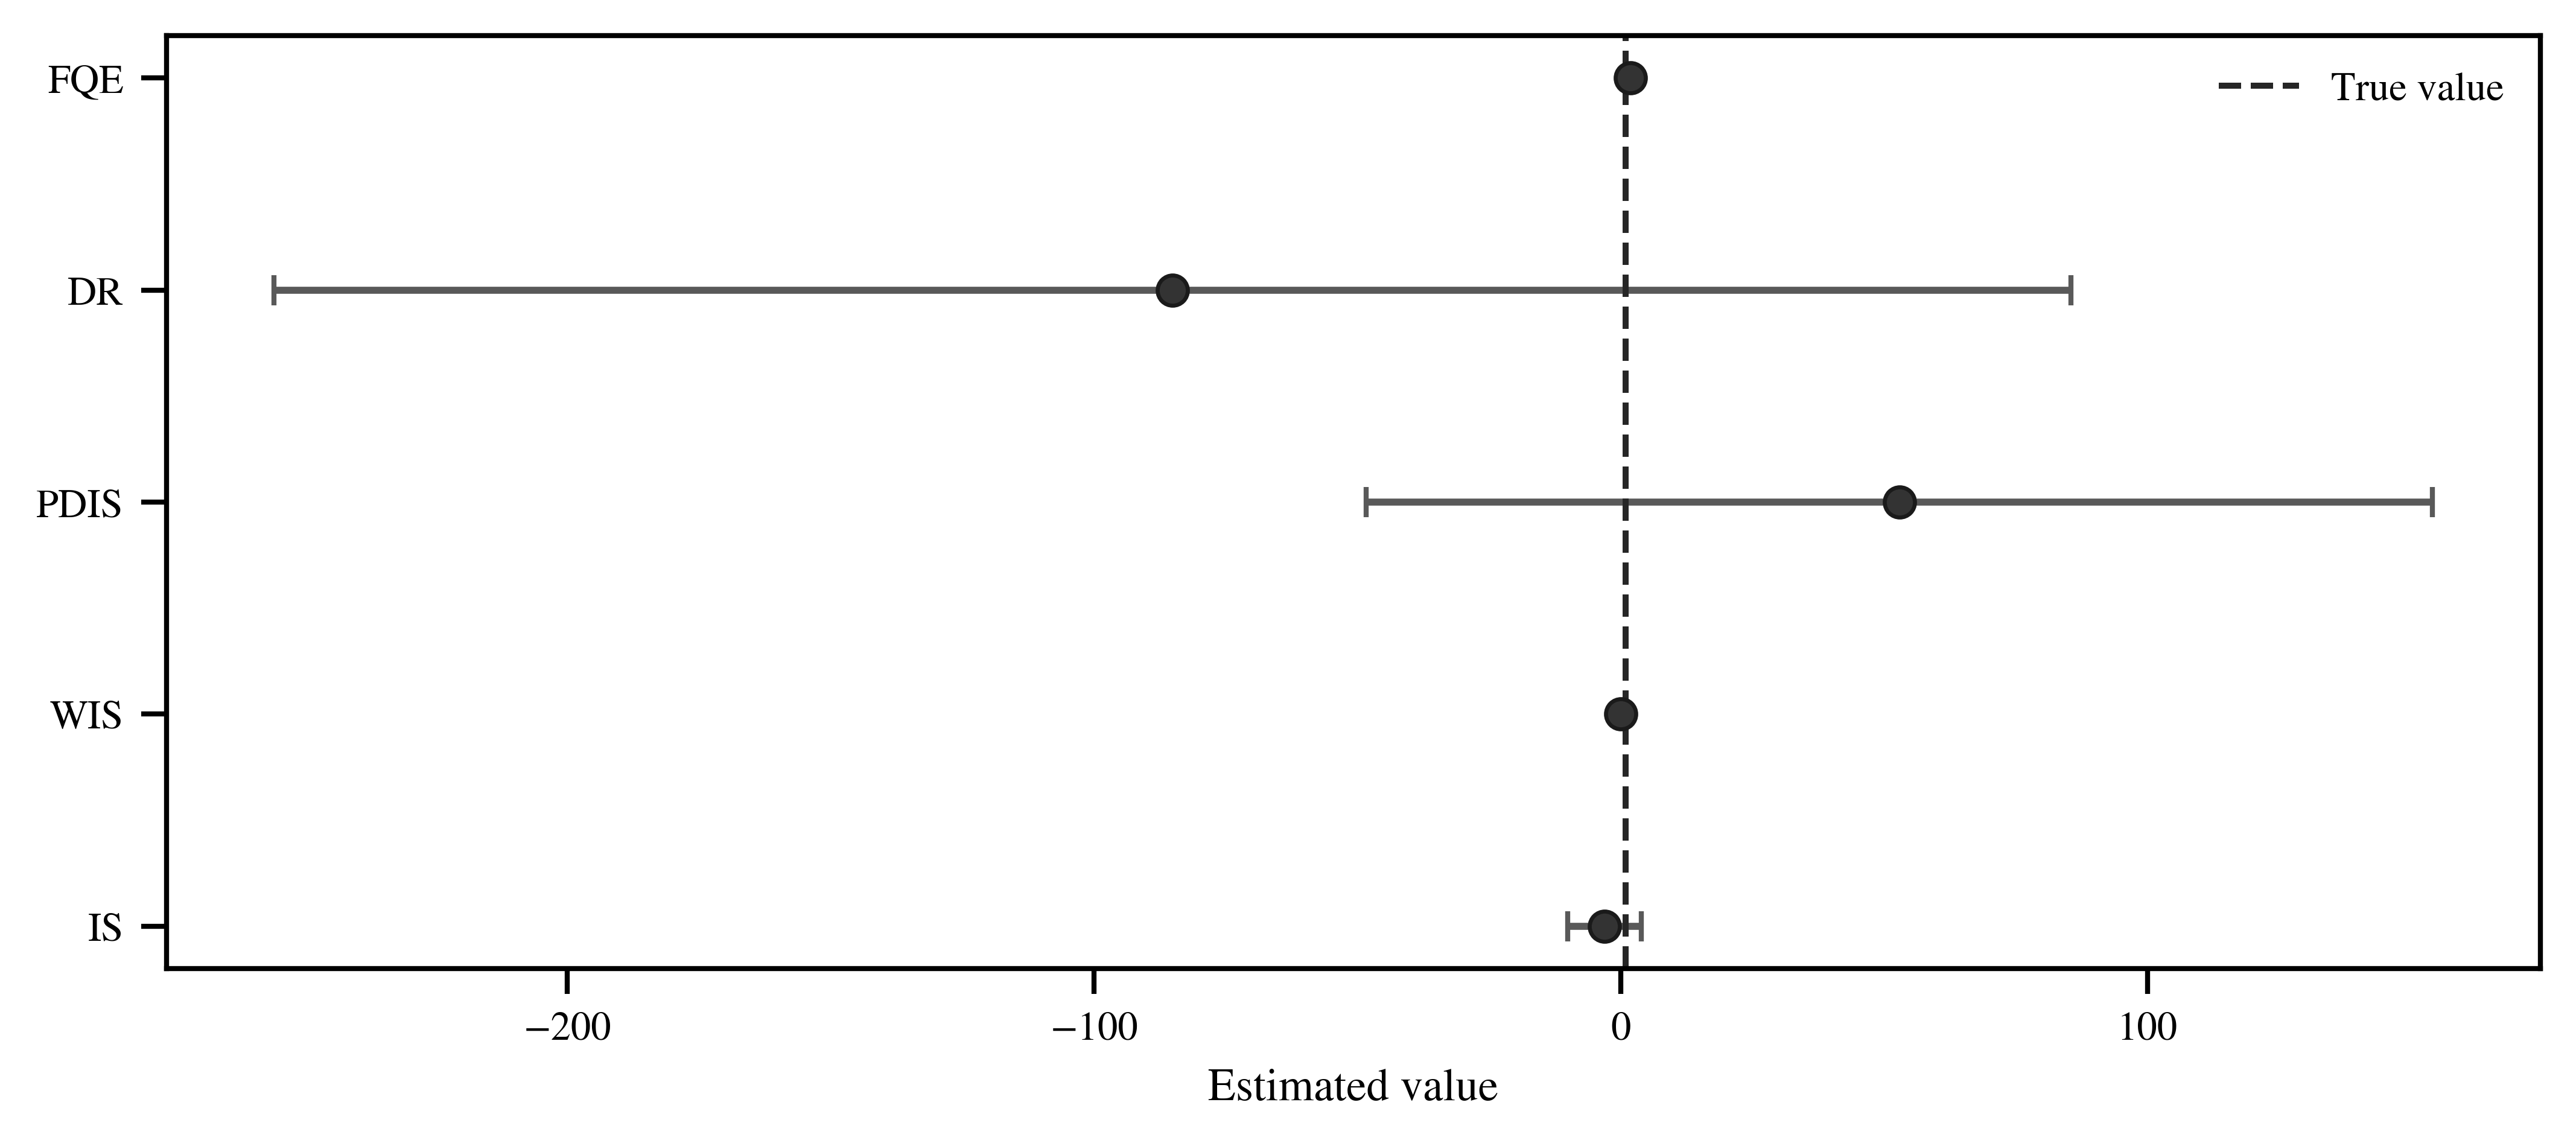

In [4]:
fig = report.plot_estimator_comparison(truth=true_value)
fig

## Save figures for docs

In [5]:
output_dir = Path("docs/assets/figures")
output_dir.mkdir(parents=True, exist_ok=True)
save_figure(fig, output_dir / "mdp_walkthrough_estimator_comparison")

{'pdf': 'docs/assets/figures/mdp_walkthrough_estimator_comparison.pdf',
 'png': 'docs/assets/figures/mdp_walkthrough_estimator_comparison.png'}

## Takeaways

- Horizon length amplifies importance-weight variance.
- DR and FQE can reduce variance but introduce model bias.
- Always inspect diagnostics alongside point estimates.